# Currency Predictor

In [65]:
! pip install prophet

In [66]:
# library import
import requests
import datetime
from io import StringIO

from prophet import Prophet
from prophet.plot import plot_plotly

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

## 1. Data exploration

### Configure currencies and dates to apply prediction

In [87]:
# Enter start & end dates
start_date = datetime.date(2021, 12, 2)
end_date = datetime.date(2022, 12, 2)

# Enter source & target currencies
source_currency = "USD"
target_currency = "INR"

### Gather FX rate data for above params from API and pre-process it

In [88]:
# functions for getting fx data from api
API_URL = "https://marketdata.tradermade.com/api/v1"

def get_api_key():
    return open("api.key", mode='r').read()


def send_api_request(url):
    headers = {'Accept': 'application/json'}
    return requests.get(url=url, headers=headers)


def get_fx_data(source_currency, target_currency, start_date, end_date):
    api_key = get_api_key()
    url = f"{API_URL}/timeseries?currency={source_currency}{target_currency}&api_key={api_key}&start_date={start_date}&end_date={end_date}&format=csv"
    return send_api_request(url).text
 

def get_currency_df(source_currency, target_currency, start_date, end_date):
    currency_rates = get_fx_data(source_currency, target_currency, start_date, end_date)
    return pd.read_csv(StringIO(currency_rates), sep=",")


currency_df = get_currency_df(source_currency, target_currency, start_date, end_date)
currency_df.tail()

,date,open,high,low,close
257,2022-11-28,81.69398,81.83900,81.58302,81.63102
258,2022-11-29,81.63102,81.74899,81.51003,81.61402
259,2022-11-30,81.63198,81.72899,81.23106,81.36195
260,2022-12-01,81.34405,81.43146,80.97109,81.17593
261,2022-12-02,81.16893,81.48396,81.07608,81.41895


### Explore data, pattern for the provided exchange rate & dates

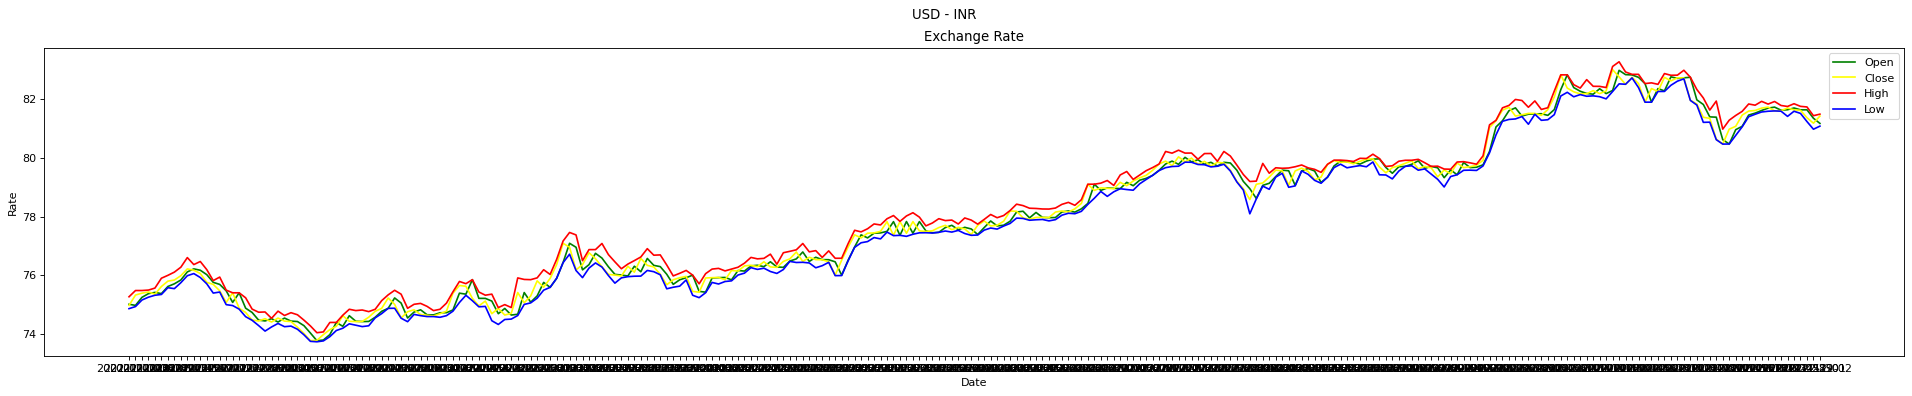

           open      high       low     close
open   1.000000  0.997484  0.997832  0.994631
high   0.997484  1.000000  0.997264  0.996937
low    0.997832  0.997264  1.000000  0.997865
close  0.994631  0.996937  0.997865  1.000000


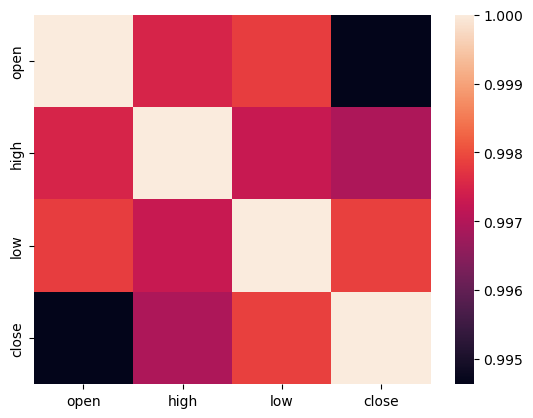

In [89]:
plt.figure(figsize=(30,5), dpi=80)
plt.suptitle(f"{source_currency} - {target_currency}")
plt.title(f"Exchange Rate")
plt.plot(currency_df['date'], currency_df['open'], color='green', label='Open')
plt.plot(currency_df['date'], currency_df['close'], color='yellow', label='Close')
plt.plot(currency_df['date'], currency_df['high'], color='red', label='High')
plt.plot(currency_df['date'], currency_df['low'], color='blue', label='Low')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Rate")
plt.show()

print(currency_df.corr())
sns.heatmap(currency_df.corr())
plt.show()

In [90]:
x = currency_df[["open", "high", "low"]].to_numpy()
y = currency_df["close"].to_numpy().reshape(-1, 1)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

## Data Analysis

### Applying Decision Tree Regressor Model

In [91]:
dtr_model = DecisionTreeRegressor()
dtr_model.fit(xtrain, ytrain)
dtr_y_pred = dtr_model.predict(xtest)

pred_data_decision_tree = pd.DataFrame(data={"Predicted Rate\n": dtr_y_pred.flatten()})
print(pred_data_decision_tree)
print("Score of the Decision Tree Regressor Model: ", dtr_model.score(xtest, ytest)*100)

    Predicted Rate\n
0           81.41895
1           81.51003
2           79.72577
3           79.80878
4           75.97646
5           78.18909
6           79.55125
7           81.41895
8           76.51572
9           77.49503
10          74.40774
11          82.28405
12          74.69000
13          79.62576
14          79.86055
15          81.63102
16          76.51572
17          75.84684
18          79.89579
19          76.76765
20          77.90260
21          77.95387
22          74.64601
23          81.58897
24          76.79275
25          79.09730
26          76.06087
27          77.37601
28          76.16243
29          75.00980
30          73.77371
31          79.62576
32          82.50092
33          76.06087
34          74.02000
35          79.82122
36          76.79275
37          82.50092
38          79.69476
39          76.47211
40          81.41895
41          74.87400
42          77.55103
43          75.98500
44          74.52225
45          79.64676
46          8

#### Plotting prediction results with actual results

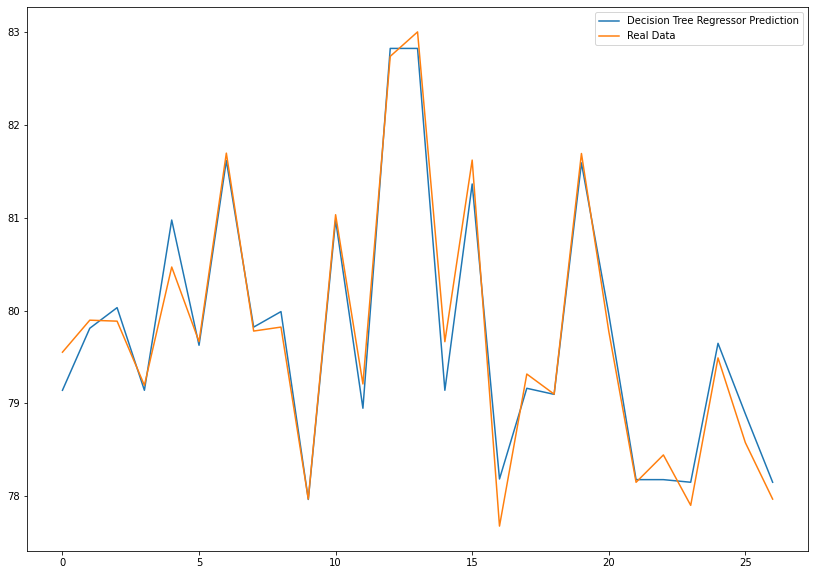

In [72]:
plt.figure(figsize=(14, 10))
plt.plot(dtr_y_pred, label = "Decision Tree Regressor Prediction")
plt.plot(ytest, label = "Real Data")
plt.legend()
plt.show()

### Applying Multilayer Perceptron (MLP)

In [73]:
mlp_model = MLPRegressor(activation='relu', max_iter = 4000, alpha = 100, hidden_layer_sizes=50, random_state=3, 
                   learning_rate_init=0.001, learning_rate='adaptive')

mlp_model.fit(xtrain, ytrain.flatten())
mlp_y_pred = mlp_model.predict(xtest)
print("Score of the MLP Model: ", mlp_model.score(xtest, ytest) * 100)

Score of the MLP Model:  95.37709237664261


#### Plotting prediction results with actual results

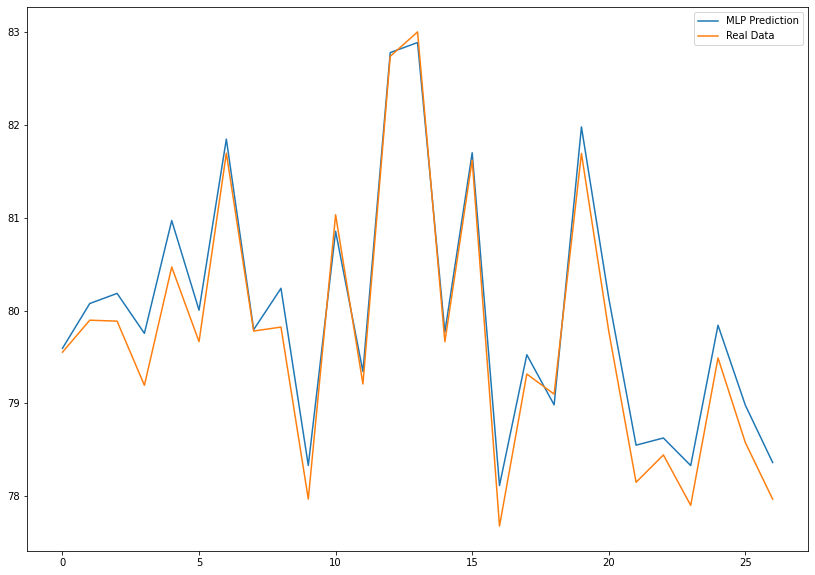

In [74]:
plt.figure(figsize=(14, 10))
plt.plot(mlp_y_pred, label = "MLP Prediction")
plt.plot(ytest, label = "Real Data")
plt.legend()
plt.show()

## Data evaluation

In [75]:
future = {
    'open' : 75.3,
    'high' : 76.2,
    'low' : 74.3
}

future_df = pd.DataFrame().append(future, ignore_index=True)
mlp_model.predict(future_df)

/var/folders/vl/8np1ysjn4m5gz6w9t5r82_vh0000gn/T/ipykernel_11997/520286635.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  future_df = pd.DataFrame().append(future, ignore_index=True)
/Users/rishank/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


array([75.58145013])

### Applying forecasting using Prophet model

In [81]:
train_dataset = pd.DataFrame()
train_dataset['ds'] = pd.to_datetime(currency_df["date"])
train_dataset['y'] = y
train_dataset.head(2)

,ds,y
0,2022-06-01,77.57663
1,2022-06-02,77.38761


In [82]:
prophet_basic = Prophet()
prophet_basic.fit(train_dataset)

00:05:07 - cmdstanpy - INFO - Chain [1] start processing
00:05:07 - cmdstanpy - INFO - Chain [1] done processing


In [83]:
future= prophet_basic.make_future_dataframe(periods=90)
future.head(2)

,ds
0,2022-06-01
1,2022-06-02


In [84]:
forecast = prophet_basic.predict(future)


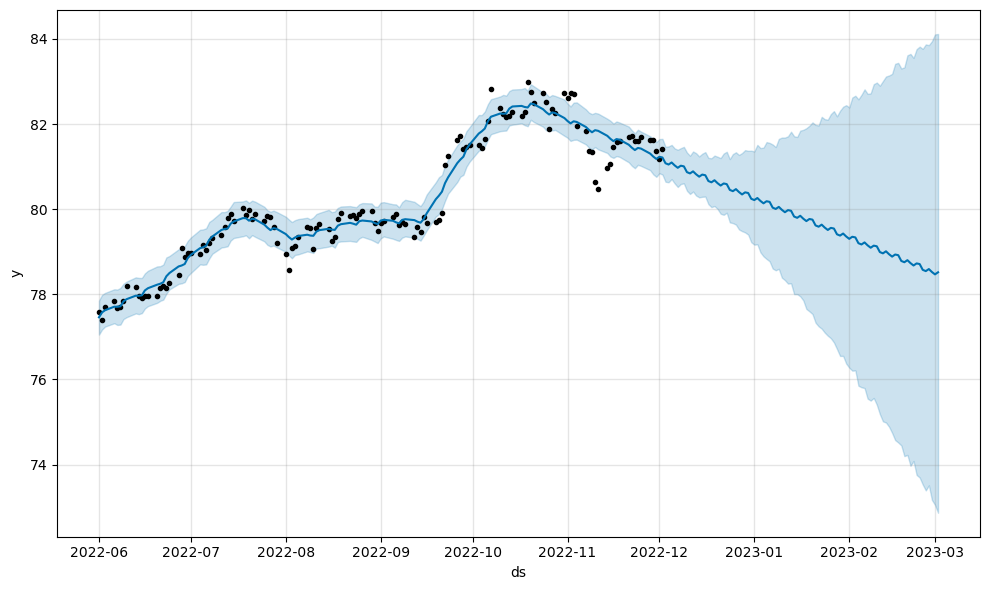

In [59]:
fig1 = prophet_basic.plot(forecast)

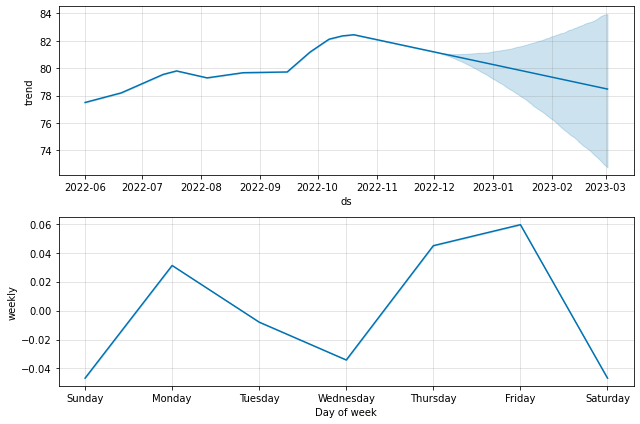

In [86]:
fig1 = prophet_basic.plot_components(forecast)


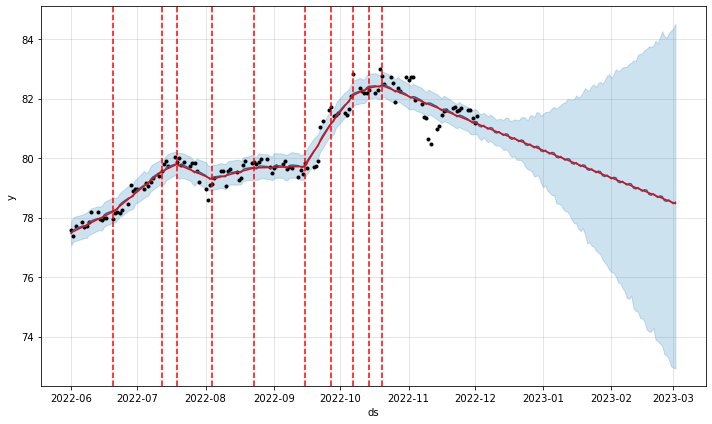

In [20]:
from prophet.plot import add_changepoints_to_plot
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)


In [21]:
prophet_basic.changepoints

4     2022-06-07
8     2022-06-13
13    2022-06-20
17    2022-06-24
21    2022-06-30
25    2022-07-06
29    2022-07-12
34    2022-07-19
38    2022-07-25
42    2022-07-29
46    2022-08-04
50    2022-08-10
55    2022-08-17
59    2022-08-23
63    2022-08-29
67    2022-09-02
71    2022-09-08
76    2022-09-15
80    2022-09-21
84    2022-09-27
88    2022-10-03
92    2022-10-07
97    2022-10-14
101   2022-10-20
105   2022-10-26
Name: ds, dtype: datetime64[ns]

23:27:19 - cmdstanpy - INFO - Chain [1] start processing
23:27:19 - cmdstanpy - INFO - Chain [1] done processing


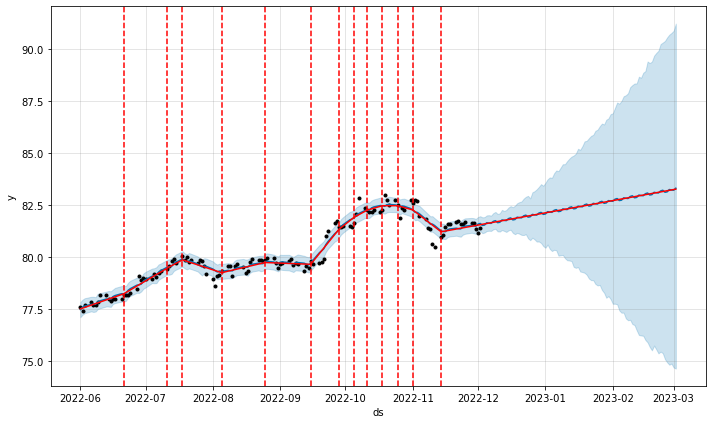

In [22]:
pro_change= Prophet(changepoint_range=0.9)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)


In [45]:
currency_df_for_regressor = pd.DataFrame()
currency_df_for_regressor['date'] = currency_df['date']
currency_df_for_regressor['y'] = currency_df['close']
currency_df_for_regressor['open'] = currency_df['open']
currency_df_for_regressor['high'] = currency_df['high']
currency_df_for_regressor['low'] = currency_df['low']

train, test = train_test_split(currency_df_for_regressor, test_size=0.3)



00:07:51 - cmdstanpy - INFO - Chain [1] start processing
00:07:52 - cmdstanpy - INFO - Chain [1] done processing


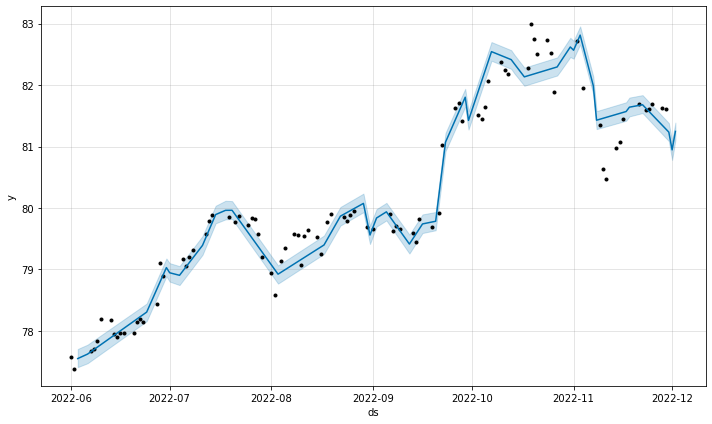

In [87]:

#Additional Regressor
pro_regressor = Prophet()
pro_regressor.add_regressor('open')
pro_regressor.add_regressor('high')
pro_regressor.add_regressor('low')



#Fitting the data
pro_regressor.fit(train)
future_data = pro_regressor.make_future_dataframe(periods=10)

#forecast the data for Test data
forecast_data = pro_regressor.predict(test)
fig1 = pro_regressor.plot(forecast_data, uncertainty=True)

In [58]:
future_data

,ds
0,2022-06-01
1,2022-06-02
2,2022-06-07
3,2022-06-08
4,2022-06-09
...,...
178,2023-02-23
179,2023-02-24
180,2023-02-25
181,2023-02-26


In [59]:
currency_df

,date,open,high,low,close
0,2022-06-01,77.63204,77.95052,77.42100,77.57663
1,2022-06-02,77.57663,77.87871,77.36000,77.38761
2,2022-06-03,77.38761,77.74010,77.37000,77.70285
3,2022-06-06,77.62303,77.90107,77.53700,77.84755
4,2022-06-07,77.84753,78.06863,77.60800,77.67934
...,...,...,...,...,...
128,2022-11-28,81.69398,81.83900,81.58302,81.63102
129,2022-11-29,81.63102,81.74899,81.51003,81.61402
130,2022-11-30,81.63198,81.72899,81.23106,81.36195
131,2022-12-01,81.34405,81.43146,80.97109,81.17593


In [55]:
currency_df.columns

Index(['date', 'open', 'high', 'low', 'close'], dtype='object')

In [94]:
# from prophet.diagnostics import cross_validation
# from prophet.diagnostics import performance_metrics

# df_cv = cross_validation(currency_df, initial='30 days', period='10 days', horizon = '15 days')


# df_p = performance_metrics(df_cv)
# df_p.head()